# Which Countries Love America the Most?


## Convert DATA

In [1]:
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [2]:
import bz2
import json
import os.path

path_to_file = './input/quotes-2019-nytimes.json.bz2'
path_to_out = './input/quotes-2019-nytimes-domains.json.bz2'

if os.path.isfile(path_to_out):
    print("The output file already exists.")
else:
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance) # loading a sample
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

The output file already exists.


## Load DATA

In [3]:
from ast import literal_eval
import pandas as pd

with open('input/data') as f:
    data = f.readlines()
    data = [literal_eval(x.strip()) for x in data]


data = pd.DataFrame(data)
data.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E,[com]
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E,"[com, com]"
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E,[com]
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E,"[com, com, com]"
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E,[com]


In [4]:
keywords = ["US", "U.S", "USA", "United States"]
mask = data.quotation.apply(lambda x: any(word in x for word in keywords))
US_data = data[mask]

print("Number of filtered quotes {} out of {}".format(len(US_data), len(data)))
US_data[['quotation', 'speaker']].head()

Number of filtered quotes 3263 out of 207527


,quotation,speaker
166,"If there was any merit to Macron's interview, ...",Emmanuel Macron
203,Don't think the U.S. is going to protect you f...,Barnett Rubin
337,This report's central conclusion is that the U...,None
385,Alfred E. Neuman cannot become president of th...,President Donald Trump
510,A strong U.S.-Philippines alliance deters aggr...,None


## Load Speakers


In [5]:
speaker_df = pd.read_parquet("input/speaker_attributes.parquet")
speaker_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


### Drop Quotes with None speakers


In [6]:
drop_mask = US_data[US_data.speaker == "None"].index
US_data = US_data.drop(drop_mask)
print("{} quotes are removed".format(len(drop_mask)))


1295 quotes are removed


### Add nationality to the main df

In [7]:
US_data["speaker_id"] = US_data.qids.map(lambda x: x[0])
US_data.head()

speaker_df = speaker_df[['id', 'nationality']]

US_merged = pd.merge(US_data, speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
print("Before : {}, After : {}".format(len(US_data), len(US_merged)))
US_merged.head()


Before : 1968, After : 1952


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,speaker_id,id,nationality
0,2019-12-02-036754,"If there was any merit to Macron's interview, ...",Emmanuel Macron,[Q3052772],2019-12-02 07:55:07,1,"[[Emmanuel Macron, 0.6888], [None, 0.1613], [I...",[http://www.nytimes.com/2019/12/02/world/europ...,E,[com],Q3052772,Q3052772,[Q142]
1,2019-10-24-005377,And I found out via a tweet that the U.S. had ...,Emmanuel Macron,[Q3052772],2019-10-24 07:00:12,1,"[[Emmanuel Macron, 0.8426], [None, 0.1444], [M...",[https://www.nytimes.com/2019/10/24/world/euro...,E,[com],Q3052772,Q3052772,[Q142]
2,2019-10-24-040910,"I understood that we were together in NATO, th...",Emmanuel Macron,[Q3052772],2019-10-24 07:00:12,1,"[[Emmanuel Macron, 0.8401], [None, 0.129], [Ma...",[https://www.nytimes.com/2019/10/24/world/euro...,E,[com],Q3052772,Q3052772,[Q142]
3,2019-08-23-030461,"I know the points of disagreement with the U.S.,",Emmanuel Macron,[Q3052772],2019-08-23 15:45:54,8,"[[Emmanuel Macron, 0.7694], [None, 0.189], [Do...",[http://nytimes.com/2019/08/23/us/politics/g7-...,E,"[com, com, com, com, com, com]",Q3052772,Q3052772,[Q142]
4,2019-11-07-121863,We should reassess the reality of what Nato is...,Emmanuel Macron,[Q3052772],2019-11-07 10:58:08,11,"[[Emmanuel Macron, 0.6947], [None, 0.1943], [P...",[http://www.breitbart.com/news/nato-allies-cla...,E,"[com, com, com, com, com, com, co.za, com, com...",Q3052772,Q3052772,[Q142]


## Get Sentiments

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
sia = SentimentIntensityAnalyzer()
US_merged["sentiment"] = US_merged.quotation.apply(lambda x: sia.polarity_scores(x)["compound"])
US_merged.head()


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,speaker_id,id,nationality,sentiment
0,2019-12-02-036754,"If there was any merit to Macron's interview, ...",Emmanuel Macron,[Q3052772],2019-12-02 07:55:07,1,"[[Emmanuel Macron, 0.6888], [None, 0.1613], [I...",[http://www.nytimes.com/2019/12/02/world/europ...,E,[com],Q3052772,Q3052772,[Q142],0.6249
1,2019-10-24-005377,And I found out via a tweet that the U.S. had ...,Emmanuel Macron,[Q3052772],2019-10-24 07:00:12,1,"[[Emmanuel Macron, 0.8426], [None, 0.1444], [M...",[https://www.nytimes.com/2019/10/24/world/euro...,E,[com],Q3052772,Q3052772,[Q142],0.0000
2,2019-10-24-040910,"I understood that we were together in NATO, th...",Emmanuel Macron,[Q3052772],2019-10-24 07:00:12,1,"[[Emmanuel Macron, 0.8401], [None, 0.129], [Ma...",[https://www.nytimes.com/2019/10/24/world/euro...,E,[com],Q3052772,Q3052772,[Q142],0.0000
3,2019-08-23-030461,"I know the points of disagreement with the U.S.,",Emmanuel Macron,[Q3052772],2019-08-23 15:45:54,8,"[[Emmanuel Macron, 0.7694], [None, 0.189], [Do...",[http://nytimes.com/2019/08/23/us/politics/g7-...,E,"[com, com, com, com, com, com]",Q3052772,Q3052772,[Q142],-0.3612
4,2019-11-07-121863,We should reassess the reality of what Nato is...,Emmanuel Macron,[Q3052772],2019-11-07 10:58:08,11,"[[Emmanuel Macron, 0.6947], [None, 0.1943], [P...",[http://www.breitbart.com/news/nato-allies-cla...,E,"[com, com, com, com, com, com, co.za, com, com...",Q3052772,Q3052772,[Q142],0.6597


### Sentiment and Countries



In [10]:
unique_countries = US_merged.nationality.explode().unique()


In [11]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']
country_dict

{'Q889': 'Afghanistan',
 'Q222': 'Albania',
 'Q262': 'Algeria',
 'Q228': 'Andorra',
 'Q916': 'Angola',
 'Q781': 'Antigua and Barbuda',
 'Q414': 'Argentina',
 'Q399': 'Armenia',
 'Q408': 'Australia',
 'Q40': 'Austria',
 'Q227': 'Azerbaijan',
 'Q398': 'Bahrain',
 'Q902': 'Bangladesh',
 'Q244': 'Barbados',
 'Q184': 'Belarus',
 'Q31': 'Belgium',
 'Q242': 'Belize',
 'Q962': 'Benin',
 'Q917': 'Bhutan',
 'Q750': 'Bolivia',
 'Q225': 'Bosnia and Herzegovina',
 'Q963': 'Botswana',
 'Q155': 'Brazil',
 'Q921': 'Brunei',
 'Q219': 'Bulgaria',
 'Q965': 'Burkina Faso',
 'Q967': 'Burundi',
 'Q424': 'Cambodia',
 'Q1009': 'Cameroon',
 'Q16': 'Canada',
 'Q1011': 'Cape Verde',
 'Q929': 'Central African Republic',
 'Q657': 'Chad',
 'Q298': 'Chile',
 'Q739': 'Colombia',
 'Q970': 'Comoros',
 'Q800': 'Costa Rica',
 'Q224': 'Croatia',
 'Q204920': 'Crown of Aragon',
 'Q241': 'Cuba',
 'Q229': 'Cyprus',
 'Q213': 'Czech Republic',
 'Q1008': "Côte d'Ivoire",
 'Q756617': 'Danish Realm',
 'Q974': 'Democratic Republic 

In [12]:
US_with_nation = US_merged.explode('nationality')
US_with_nation.nationality = US_with_nation.nationality.map(country_dict)
US_with_nation.sample(n=20,random_state=711)



,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,speaker_id,id,nationality,sentiment
1656,2019-06-28-016570,Every day I hear it: `I'm leaving for the Unit...,Víctor Manuel,[Q3176413],2019-06-28 22:03:01,5,"[[Víctor Manuel, 0.5761], [None, 0.4087], [Alb...",[http://nytimes.com/2019/06/28/world/americas/...,E,"[com, com, com, com, com]",Q3176413,Q3176413,Spain,0.4215
361,2019-04-29-012525,China consistently opposes U.S. unilateral san...,Geng Shuang,[Q27612210],2019-04-29 02:36:57,5,"[[Geng Shuang, 0.718], [None, 0.225], [Steven ...",[http://mobile.nytimes.com/2019/04/28/us/polit...,E,"[com, com, com, com, pk]",Q27612210,Q27612210,People's Republic of China,0.0000
1112,2019-11-23-040193,Thank God nobody is accusing us anymore of int...,Vladimir Putin,[Q7747],2019-11-23 19:30:06,8,"[[Vladimir Putin, 0.6711], [Fiona Hill, 0.1528...",[https://www.nytimes.com/2019/11/23/opinion/su...,E,"[com, com, com, com, com, com, com, com]",Q7747,Q7747,Russia,0.4404
1349,2019-05-21-103628,This team might be the best team U.S.A. has ha...,Jack Hughes,"[Q53952401, Q608218, Q6113254]",2019-05-21 04:14:06,1,"[[Jack Hughes, 0.9232], [None, 0.0768]]",[http://www.nytimes.com/2019/05/21/sports/jack...,E,[com],Q53952401,Q53952401,NaN,0.6369
279,2019-08-20-102144,"We've made clear, anyone who touches it, anyon...",Mike Pompeo,[Q473239],2019-08-20 23:56:27,1,"[[Mike Pompeo, 0.8772], [None, 0.1228]]",[http://www.nytimes.com/2019/08/20/world/middl...,E,[com],Q473239,Q473239,United States of America,0.7003
673,2019-07-16-050887,just shows a fundamental misunderstanding of t...,Jim Himes,[Q1689111],2019-07-16 17:41:58,1,"[[Jim Himes, 0.3857], [President Trump, 0.3347...",[http://nytimes.com/2019/07/16/us/politics/for...,E,[com],Q1689111,Q1689111,United States of America,0.0000
89,2019-10-23-120765,"We've secured the oil and, therefore, a small ...",President Donald Trump,[Q22686],2019-10-23 10:40:57,228,"[[President Donald Trump, 0.6023], [None, 0.38...",[http://www.al-monitor.com/pulse/originals/201...,E,"[com, com, pk, com, com, com, com, com, com, c...",Q22686,Q22686,United States of America,0.4588
81,2019-02-06-098843,The U.S. economy is growing almost twice as fa...,President Donald Trump,[Q22686],2019-02-06 01:58:21,5,"[[President Donald Trump, 0.5836], [None, 0.39...",[https://www.nytimes.com/2019/02/05/us/politic...,E,"[com, com, co.uk, com, com]",Q22686,Q22686,United States of America,0.1779
782,2019-04-01-120043,When the U.S. Secretary of Education's own alm...,Esther Warkov,[Q47485427],2019-04-01 15:50:18,1,"[[Esther Warkov, 0.8846], [None, 0.1031], [Bet...",[http://www.nytimes.com/2019/04/01/us/politics...,E,[com],Q47485427,Q47485427,NaN,-0.2732
322,2019-07-31-024098,I don't understand why anybody goes to all the...,Elizabeth Warren,[Q434706],2019-07-31 16:34:10,2,"[[Elizabeth Warren, 0.7455], [None, 0.1882], [...",[https://www.portlandmercury.com/blogtown/2019...,E,"[com, com]",Q434706,Q434706,United States of America,0.3147


### Billion-Dollar Question: How much people love US?


<AxesSubplot:title={'center':'Number of quotes'}, ylabel='nationality'>

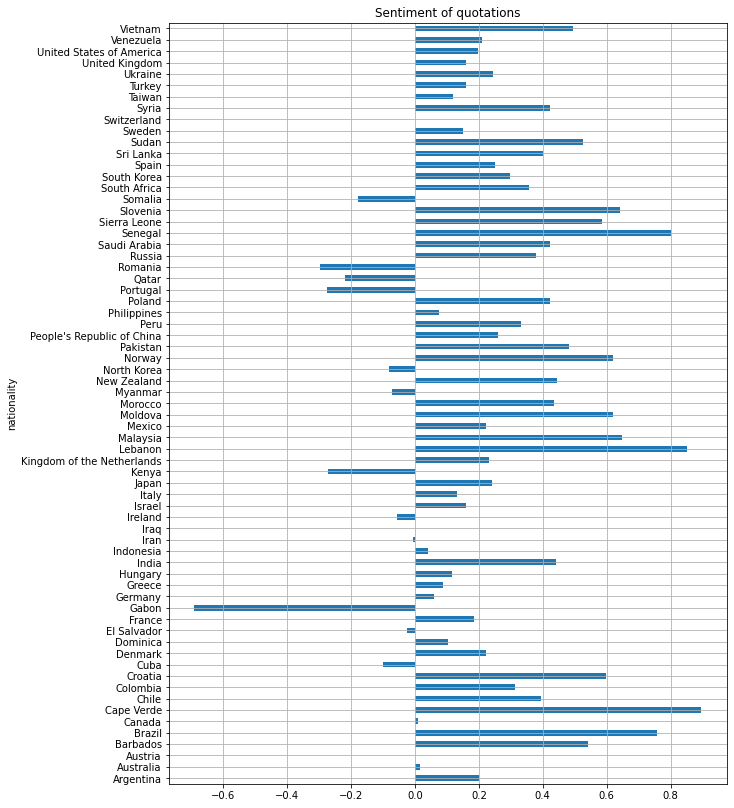

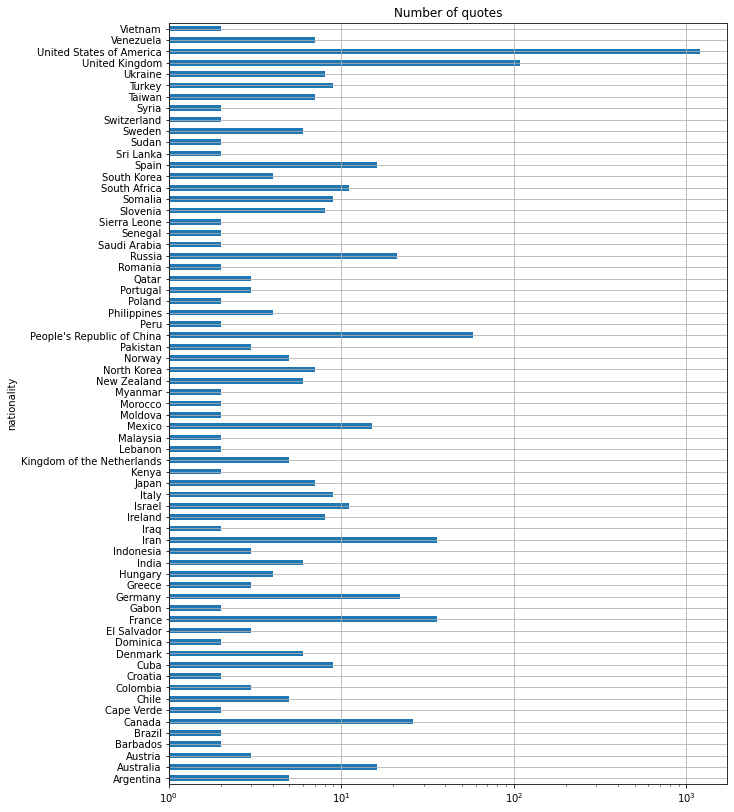

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 14))
plt.title("Sentiment of quotations")
US_love_mean = US_with_nation.groupby("nationality")["sentiment"].mean()
US_with_nation.groupby("nationality")["sentiment"].mean().plot.barh(grid=True)

plt.figure(figsize=(10,14))
plt.title("Number of quotes")
US_with_nation.groupby("nationality")["sentiment"].count().plot.barh(grid=True, log=True, align='center')


In [14]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
table = world.merge(US_love_mean, how="left", left_on=['name'], right_on=['nationality'])


# Clean data: remove rows with no data
table = table.dropna(subset=['sentiment'])
table.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sentiment
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.008124
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.197135
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",0.040750
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",0.200125
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",0.396150


In [15]:
import folium

my_map = folium.Map()

# Add the data
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'sentiment'],
    key_on='feature.properties.name',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sentiment of Quotes',
    missing_kwds={'color': 'white'}
).add_to(my_map)
my_map.save('us_love.html')